In [18]:
import itertools
import numpy as np

# ==== パラメータ設定 ====
num_orbitals = 6
num_particles = 3
delta = 1.0   # 1体項の等間隔エネルギー
v = 0.3       # 2体相互作用（ペア＋単粒子遷移含む）
w3 = 0.2      # 3体相互作用

# ==== 基底生成 ====
def generate_basis(num_orbitals, num_particles):
    basis = []
    for bits in itertools.combinations(range(num_orbitals), num_particles):
        occ = np.zeros(num_orbitals, dtype=int)
        occ[list(bits)] = 1
        basis.append(tuple(occ))
    return basis

basis = generate_basis(num_orbitals, num_particles)
dim = len(basis)

# ==== 生成消滅演算の定義 ====
def apply_annihilate(state, i):
    state = list(state)
    if state[i] == 0:
        return None, 0
    sign = (-1)**sum(state[:i])
    state[i] = 0
    return tuple(state), sign

def apply_create(state, i):
    state = list(state)
    if state[i] == 1:
        return None, 0
    sign = (-1)**sum(state[:i])
    state[i] = 1
    return tuple(state), sign

def apply_cdag_c(state, i, j):
    """c_i† c_j"""
    s1, sign1 = apply_annihilate(state, j)
    if s1 is None:
        return None, 0
    s2, sign2 = apply_create(s1, i)
    if s2 is None:
        return None, 0
    return s2, sign1 * sign2

# ==== 1体ハミルトニアン ====
H1 = np.zeros((dim, dim))
for p, s in enumerate(basis):
    for i, occ in enumerate(s):
        if occ == 1:
            energy = delta * (i // 2)  # 各2縮退レベルごとに等間隔
            H1[p, p] += energy

# ==== 2体ハミルトニアン（改訂版）====
pairs = [(0, 1), (2, 3), (4, 5)]
H2 = np.zeros((dim, dim))

def find_pair_and_single(state):
    """3粒子状態から (pair_index, single_orbital) を特定"""
    for p_idx, (a, b) in enumerate(pairs):
        if state[a] == 1 and state[b] == 1:
            s = [i for i in range(len(state)) if state[i] == 1 and i not in (a, b)][0]
            return p_idx, s
    return None, None

# すべてのペア・単粒子遷移を許す
for i, bra in enumerate(basis):
    p_bra, s_bra = find_pair_and_single(bra)
    if p_bra is None:
        continue  # ペアがない状態は作用しない

    for j, ket in enumerate(basis):
        p_ket, s_ket = find_pair_and_single(ket)
        if p_ket is None:
            continue

        # ペアと単粒子の両方が遷移できる
        # 全結合を許して同一強度v
        H2[i, j] += v



# ==== 3体ハミルトニアン（変更なし）====
triplets = [(0,1,2), (1,2,3), (2,3,4), (3,4,5)]
H3 = np.zeros((dim, dim))

for T1 in triplets:
    for T2 in triplets:
        for i, s in enumerate(basis):
            if all(s[k] == 1 for k in T2):
                s_new = list(s)
                sign = 1
                # アニヒレート
                for k in reversed(T2):
                    s_new, sgn = apply_annihilate(s_new, k)
                    if s_new is None:
                        break
                    sign *= sgn
                if s_new is None:
                    continue
                # クリエイト
                for k in T1:
                    s_new, sgn = apply_create(s_new, k)
                    if s_new is None:
                        break
                    sign *= sgn
                if s_new is None:
                    continue
                s_new = tuple(s_new)
                if s_new in basis:
                    j = basis.index(s_new)
                    H3[i, j] += w3 * sign

# ==== 総ハミルトニアン ====
H = H1 + H2 + H3
H = (H + H.conj()) / 2  # Hermitian化

# ==== 結果表示 ====
np.set_printoptions(precision=2, suppress=True)
print("Hamiltonian matrix (dim={}):".format(dim))
print(H)

# ==== 固有値 ====
eigvals, _ = np.linalg.eigh(H)
print("\nEigenvalues:")
print(np.round(eigvals, 4))

print("\nNonzero elements in H2:", np.count_nonzero(H2))

Hamiltonian matrix (dim=20):
[[1.5 0.3 0.3 0.3 0.3 0.  0.  0.  0.  0.3 0.5 0.  0.  0.  0.  0.3 0.5 0.3
  0.3 0.5]
 [0.3 1.3 0.3 0.3 0.3 0.  0.  0.  0.  0.3 0.3 0.  0.  0.  0.  0.3 0.3 0.3
  0.3 0.3]
 [0.3 0.3 2.3 0.3 0.3 0.  0.  0.  0.  0.3 0.3 0.  0.  0.  0.  0.3 0.3 0.3
  0.3 0.3]
 [0.3 0.3 0.3 2.3 0.3 0.  0.  0.  0.  0.3 0.3 0.  0.  0.  0.  0.3 0.3 0.3
  0.3 0.3]
 [0.3 0.3 0.3 0.3 2.3 0.  0.  0.  0.  0.3 0.3 0.  0.  0.  0.  0.3 0.3 0.3
  0.3 0.3]
 [0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.3 0.3 0.3 0.3 0.3 0.  0.  0.  0.  4.3 0.3 0.  0.  0.  0.  0.3 0.3 0.3
  0.3 0.3]
 [0.5 0.3 0.3 0.3 0.3 0.  0.  0.  0.  0.3 2.5 0.  0.  0.  0.  0.3 0.5 0.3
  0.3 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

In [19]:
import itertools
import numpy as np

# ==== 全基底（64次元） ====
all_basis = [tuple(int(x) for x in format(i, '06b')) for i in range(2**6)]

# ==== 3粒子空間の基底インデックスを求める ====
basis_index = [all_basis.index(b) for b in basis]

# ==== 20次元→64次元への埋め込み ====
H_full = np.zeros((64, 64), dtype=complex)
for i, bi in enumerate(basis_index):
    for j, bj in enumerate(basis_index):
        H_full[bi, bj] = H[i, j]

# ==== パウリ行列定義 ====
I = np.array([[1,0],[0,1]])
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
paulis = [I, X, Y, Z]
labels = ['I','X','Y','Z']

# ==== Pauli 展開 ====
coeffs = {}
for ops in itertools.product(range(4), repeat=6):
    P = paulis[ops[0]]
    for k in ops[1:]:
        P = np.kron(P, paulis[k])
    c = np.trace(P @ H_full) / 64
    if abs(c) > 1e-8:
        label = ''.join(labels[k] for k in ops)
        coeffs[label] = np.real_if_close(c)

# ==== 出力 ====
print(f"\nNonzero Pauli terms ({len(coeffs)} terms):")
for k, v in sorted(coeffs.items(), key=lambda x: -abs(x[1])):
    print(f"{k:10s} : {v:.6f}")



Nonzero Pauli terms (652 terms):
IIIIII     : 1.006250
ZZZZZZ     : -1.006250
IIZIIZ     : -0.218750
IZIIZI     : -0.218750
IZZIZZ     : 0.218750
ZIIZII     : -0.218750
ZIZZIZ     : 0.218750
ZZIZZI     : 0.218750
IIZIZI     : -0.212500
IZIIIZ     : -0.212500
ZIZZZI     : 0.212500
ZZIZIZ     : 0.212500
IZIZII     : -0.212500
ZIZIZZ     : 0.212500
IZZZIZ     : 0.212500
ZIIIZI     : -0.212500
IZZZZI     : 0.206250
ZIIIIZ     : -0.206250
IZIZZZ     : 0.206250
ZIZIII     : -0.206250
IIIZIZ     : -0.206250
ZZZIZI     : 0.206250
IZZIII     : -0.200000
ZIIZZZ     : 0.200000
IIIZZI     : -0.200000
ZZZIIZ     : 0.200000
IZZZZZ     : -0.193750
ZIIIII     : 0.193750
IIIIZI     : -0.187500
IZIIII     : 0.187500
ZIZZZZ     : -0.187500
ZZZZIZ     : 0.187500
IIIIIZ     : -0.181250
ZZZZZI     : 0.181250
IIZZII     : -0.168750
ZZIIZZ     : 0.168750
IIIIZZ     : -0.162500
ZZZZII     : 0.162500
IIZZZZ     : 0.162500
ZZIIII     : -0.162500
IIZIZZ     : 0.125000
ZZIZII     : -0.125000
IIIZZZ     : 0.125000

In [20]:
# ==== 出力ファイルに書き出し ====
output_file = "pauli_expansion.txt"

with open(output_file, "w") as f:
    f.write("# Pauli expansion of the 6-qubit Hamiltonian\n")
    f.write("# Format: PauliString   Coefficient (real)\n\n")
    for k, v in sorted(coeffs.items(), key=lambda x: -abs(x[1])):
        f.write(f"{k:10s} {v:.10f}\n")

print(f"\nPauli expansion written to: {output_file}")



Pauli expansion written to: pauli_expansion.txt


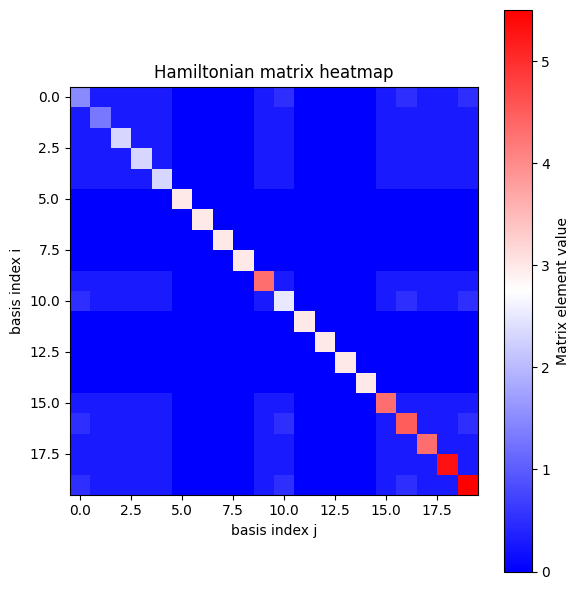

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.imshow(H, cmap="bwr", interpolation="nearest")
plt.colorbar(label="Matrix element value")
plt.title("Hamiltonian matrix heatmap")
plt.xlabel("basis index j")
plt.ylabel("basis index i")
plt.tight_layout()
plt.show()